# Compressing Data via Dimensionality Reduction

In previous chapter we learned about the different approaches for reducing the dimensionality of a dataset using different feature selection techniques. An alternative approach to feature selection for dimensionality reduction is **feature extraction**. In this chapter, you will learn about three fundamental techniques that will help us to summarize the information content of a dataset by transforming it onto a new feature subspace of lower dimensionality than the original one. Data compression is an important topic in machine learning, and it helps us to store and analyse the increasing amount of data that are produced and collected in the modern age of technology.

In this chapter, we will cover the folloing topics: 
* **Principal Component Analysis (PCA)** for unsupervised data compression. 
* **Linear Discriminant Analysis (LDA)** as a supervised dimensionality reduction technique for maximizing class separability. 
* Non dimensionality reduction via **Kernel Principal Component Analysis (KPCA)**. 

## Unsupervised dimensionality reduction via principal component analysis

Similar to feature selection, we can use different feature extraction techniques to reduce the number of features in the dataset. The difference between feature selection and feature extraction is that while we maintain the original features when we used feature selection algorithms, such as *sequential backward selection*, we use feature extraction to transform or project the data onto a new feature space. In the context of dimensionality reduction, feature extraction can be understood as an approach to data compression with the goal of maintaning most of the relevant information. In practice, feature extraction is not only used to improve storage space or the computational efficiency of the learning algorithm, but can also improve the predictive performance by reducing the *curse of dimensionality*; especially if we are working with non-regularized models. 

## The main steps behind principal component analysis

In this section, we will discuss PCA, an unsupervised linear transformation technique that is widely used across different fields, most prominently for feature extraction and dimensionality reduction. Other popular applications of PCA include exploratory data analyses and de-noising of signals in stock market trading, and the analysis of genome data and gene expression levels in the field of bioinformatics. 

PCA helps us to identify patters in data based on the correlation between features. In a nutshell, PCA aims to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one. The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum variance ginve the constraint that the new feature axes are orthogonal to each other, as illustrated in the following figure:

<img src='images/05_01.png'>

In the preceding figure, $x_1$ and $x_2$ are the original features axes and **PC1** and **PC2** are the principal components. 

If we use PCA for dimensionality reduction, we construct a $d \times k$-dimensional transformation matrix **W** that allows us to map a sample vector **x** onto a new $k$-dimensional feature subspace that has fewer dimensions than then original $d$-dimensional feature. 

As a result of transforming the original $d$-dimensional data onto this new $k$-dimensional subspace (typically $k << d$), the first principal component will have the largest possible variance, and all consequent principal component will have the largest variance given the constraint that these components are uncorrelated (orthogonal) to the other principal component; even if the input features are correlated, the resulting principal components will be mutually orthogonal (uncorrelated). Note that the PCA directions are highly sensitive to data scaling, and we need to standardize the features **prior** to PCA if the features were measured on different scales and we want to assign equal importance to all features. 

Before looking at the PCA algorithm for dimensionality reduction in more detail, let's summarize the approach in a few simple steps: 

1. Standardize the $d$-dimensional dataset. 
2. Construct the covariance matrix. 
3. Decompose the covariance matrix into its eigenvectors and eigenvalues. 
4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors. 
5. Select $k$ eigenvectors which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace ($k \le d$).
6. Construct a projection matrix **W** from the "top" $k$ eigenvectors. 
7. Transform the $d$-dimensional input dataset **X** using the projection matrix **W** to obtain the new $k$-dimensional feature subspace. 

In the following sections, we will perform a PCA step by step, using Python as a learning exercise. Then, we will see how perform a PCA more conveniently using scikit-learn. 

## Extracting the principal components step by step

In this subsection, we will tackle the first four steps of a PCA: 

1. Standardize the data. 
2. Constructing the covariance matrix. 
3. Obtaining the eigenvalues and eigenvectors of the covariance matrix. 
4. Sorting the eigenvalues by decreasing order to rank the eigenvectors. 

First, we will start by loading the Wine dataset that we have been working with:

In [1]:
import pandas as pd

df_wine = pd.read_csv('wine.data', header=None)

Next, we will process the Wine data into separate training and test sets; using 70 percent and 30 percent of the data, respectively, and stardardize it to unit variance: 

In [2]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y, random_state=0)
    
# standardize the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

After completing the mandatory preprocessing by executing the preceding code, let's advance to the second step: constructing the covariance matrix. The symmetric $d \times d$-dimensional covariance matrix, where $d$ is the number of dimensions in the dataset, stores the pairwise covariances between the different features. 

A positive covariance between two features indicates that the features increase or decrease together, whereas a negative covariance indicates that the features vary in opposite directions. 

The eigenvectors of the covariance matrix represent the principal components (the directions of maximum variance), whereas the corresponding eigenvalues will define their magnitude. In the case of the Wine dataset, we would obtain 13 eigenvectors and eigenvalues from the $13 \times 13$-dimensional covariance matrix. 

Now, for our third step, let's obtain the eigenpairs of the covariance matrix. Since the manual computation of eigenvectors and eigenvalues is a somewhat tedious and elaborate task, we will use the *linalg.eig* function from NumPy to obtain the eigenpairs of the Wine covariance matrix: 

In [3]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


Using the *numpy.cov* function, we computed the covariance matrix of standardized training dataset. Using the *linalg.eig* function, we performed the eigendecomposition, which yielded a vector (*eigen_vals*) consisting of 13 eigenvalues and the corresponding eigenvectors stored as columns in a $13 \times 13$-dimensional matrix (*eigen_vec*). 

## Total and explained variance

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance). The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude; we are interested in the top $k$ eigenvectors based on the values of their corresponding eigenvalues. But before we collect those $k$ most informative eigenvectors, let us plot the *variance explained ratios* of the eigenvalues. Using the NumPy *cumsum* function, we can then calculate the cumulative sum of explained variances, which we will then plot via Matplotlib's *step* function: 

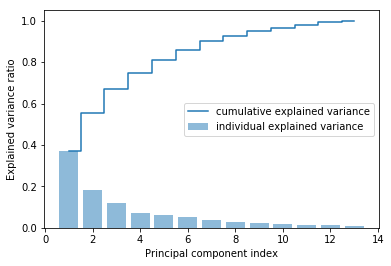

In [4]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid', 
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

The resulting plot indicates that the first principal component alone accounts for approximately 40 percent of the variance. Also, we can see that the first two principal components combined explain almost 60 percent of the variance in the dataset. 

Although the explained variance plot reminds us of the feature importance values that we computed via random forests, we should remind ourselves that PCA is an unsupervised method, which means that information about the class labels are ignored. Whereas a random forest uses the class membership information to compute the node impurities, variance measures the spread of values along the feature axis. 

## Feature transformation

After we have successfully decomposed the covariance matrix into eigenpairs, let's now proceed with the last three steps to transform the Wine dataset onto the new principal component axes. The remaining steps we are going to tackle in this section are the following ones: 
* Select $k$ eigenvectors, which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace ($k \le d$). 
* Construct a project matrix **W** from the "top" $k$ eigenvectors. 
* Transform the $d$-dimensional input dataset **X** using the projection matrix **W** to obtain the new $k$-dimensional feature subspace. 

Or, in less technical terms, we will sort the eigenpairs by descending order of the eigenvalues, construct a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the lower-dimensional subspace. 

We start by sorting the eigenpairs by decreasing order of the eigenvalues:

In [5]:
# Make a list of the (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) 
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

Next, we collect the two eigenvectors that correspond to the two largest eigenvalues, to capture about 60 percent of the variance in this dataset. Note that we only chose two eigenvectors for the purpose of illustration, since we are going to plot the data via a two-dimensional scatter plot later in this subsection. In practice, the number of principal components has to be determined by a trade-off between computational efficiency and the performance of the classifier: 

In [6]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], 
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


By executing the preceding code, we have created a $13 \times 2$-dimensional projection matrix **W** from the top two eigenvectors. 

Using the projection matrix, we can now transform a sample **x** (represented as a $1 \times 13$-dimensional row vector) onto the PCA subspace (the principal components one and two) obtaining $\boldsymbol{x'}$, now a two-dimensional sample vector consisting of two new features: 

In [7]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

Similarly, we can transform the entire $124 \times 13$-dimensional training dataset onto the two principal components by calculating the matrix dot product: 

In [8]:
X_train_pca = X_train_std.dot(w)

Lastly, let us visualize the transformed Wine training set, now stored as an $124 \times 2$-dimensional matrix, in a two-dimensional scatterplot: 

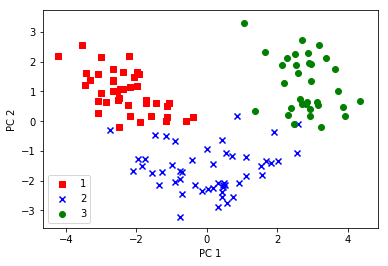

In [9]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

As we can see in the resulting plot, the data is more spread along the *x*-axis; the first principal component; than the second principal component (*y*-axis), which is consistent with the explained variance ratio plot that we created in the previous subsection. However, we can intuitively see that a linear classifier will likely be able to separate the class well. 

Although we encoded the class label information for the purpose of illustration in the preceding scatter plot, we have to keep in mind that PCA is an unsupervised technique that doesn't use any class label information. 

## Principal component analysis in scikit-learn

Although the verbose approach in the previous subsection helped us to follow the inner workings of PCA, we will now discuss how to use the *PCA* class implemented in scikit-learn. The *PCA* class is another one of scikit-learn's transformer classes, where we first fit the model using the training data before we transform both the training and test dataset using the same model paramters. Now, let's use the *PCA* class from scikit-learn on the Wine training dataset, classify the transformed samples via logistic regression, and visualize the decision regions via the *plot_decision_region* function:

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], 
                    alpha=0.6, c=cmap(idx), 
                    edgecolor='black', marker=markers[idx], 
                    label=cl)

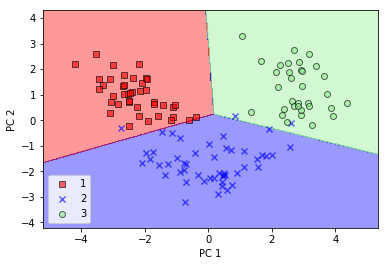

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

When we compare PCA projections via scikit-learn with our own PCA implementation, it can happen that the resulting plots are mirror images of each other. Note that this is not due to an error in either of those two implementations, but the reason of this difference is that, depending on the eigensolver, eigenvectors can have either negative or positive signs. Not that it matters, but we could simply revert the mirror image by multiplying the data by *-1* if we wanted to; note that eigenvectors are typically scaled to unit length 1. For the sake of completeness, let's plot the decision regions of the logistic regression on the transformed test dataset to see if it can separate the classes well:

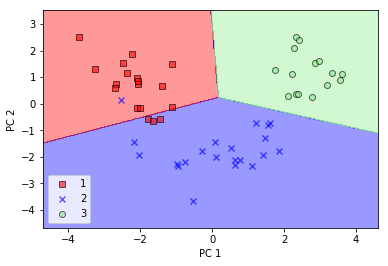

In [12]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

If we are interested in the explained variance ratios of the different principal components, we can simply initialize the *PCA* class with the *n_components* parameter set to *None*, so all principal components are kept and the explained variance ratio can then be accessed via the *explained_variance_ratio_* attribute: 

In [13]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

Note that we set *n_components=None* when we initialized the *PCA* class so that it will return all principal components in a sorted order instead of performing a dimensionality reduction. 

## Supervised data compression via linear discriminant analysis

**Linear Discriminant Analysis (LDA)** can be used as a technique for feature extraction to increase the computational efficiency and reduce the degree of overfitting due to the curse of dimensionality in non-regularized models. 

The general concept behind LDA is very similar to PCA. Whereas PCA attempts to find the orthogonal component axes of maximum variance in a dataset, the goal in LDA is to find the feature subspace that optimizes class separability. In the following sections, we will discuss the similarities between LDA and PCA in more detail and walk through the LDA approach step by step. 

## Principal component analysis versus linear discriminant analysis

Both LDA and PCA are linear transformation techniques that can be used to reduce the number of dimensions in a dataset; the former is an unsupervised algorithm, whereas the latter is supervised. Thus, we might intuitively think that LDA is a superior feature extraction technique for classification tasks compared to PCA. However, A.M. Martinez reported that preprocessing via PCA tends to result in better classification results in an image recognition task in certain cases, for instance if each class consists of only a small number of samples. 

The following figure summarizes the concept of LDA for a two-class problem. Samples from class 1 are shown as circles, and samples from class 2 are shown as crosses. 

<img src='images/05_06.png'>

A linear discriminant, as shown on the $x$-axis (LD 1), would separate the two normal distributed classes well. Although the exemplary linear discriminant shown on the $y$-axis (LD 2) captures a lot of the variance in the dataset, it would fail as a good linear discriminant since it does not capture any of the class-discriminatory information. 

Once assumption in LDA is that the data is normally distributed. Also, we assume that the classes have identical covariance matrices and that the features are statistically independent for each other. However, even if one or more of those assumptions are (slightly) violated, LDA for dimensionality reduction can still work reasonably well. 

## The inner workings of linear discriminant analysis

Before we dive into the code implementation, let's briefly summarize the main steps that are required to perform LDA:

1. Standardize the *d*-dimensional dataset (*d* is the number of features). 
2. For each class, compute the *d*-dimensional mean vector. 
3. Construct the between-class scatter matrix $S_B$ and the within-class scatter matrix $S_w$. 
4. Compute the eigenvectors and corresponding eigenvalues of the matrix $S_w^{-1}S_B$. 
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors. 
6. Choose the *k* eigenvectors that correspond to the *k* largest eigenvalues to construct a $d \times k$-dimensional transformation matrix $W$; the eigenvectors are the columns of this matrix. 
7. Project the samples onto the new feature subspace using the transformation matrix $W$. 

As we can see, LDA is quite similar to PCA in the sense that we are decomposing matrices into eigenvalues and eigenvectors, which will form the new lower-dimensional feature space. However, as mentioned before, LDA takes class label information into account, which is represented in the form of the mean vectors computed in step 2. In the following sections, we will discuss these seven steps in more detail, accompanied by illustrative code implementations. 

## Computing the scatter matrices

Since we already standardized the features of the Wine dataset in the PCA section at the beginning of this chapter, we can skip the first step and proceed with the calculation of the mean vectors, which we will use to construct the within-class scatter matrix and between-class scatter matrix, respectively. 

In [14]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Using the mean vectors, we can now compute the within-class scatter matrix $S_W$. This is calculated by summing up the individual scatter matrices $S_i$ of each individual class $i$: 

In [15]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


The assumption that we are making when we are computing the scatter matrices is that the class labels in the training set are uniformly distributed. However, if we print the number of class labels, we see that this assumption is violated: 

In [16]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


Thus, we want to scale the individual scatter matrices $S_i$ before we sum them up as scatter matrix $S_W$. 

In [17]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


After we computed the scaled within-class scatter matrix (or covariance matrix), we can move on to the next step and compute the between-class scatter matrix $S_B$:

In [18]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec-mean_overall).dot((mean_vec-mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


## Selecting linear discriminants for the new feature subspace

The remaining steps of the LDA are similar to the steps of the PCA. However, instead of performing the eigendecomposition on the covariance matrix, we solve the generalized eigenvalue problem of the matrix $S_W^{-1}S_B$:

In [19]:
eigen_vals, eigen_vecs = \
    np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

After we computed the eigenpairs, we can now sor the eigenvalues in descending order:

In [20]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) 
                for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.617808905994
172.76152218979382
5.684341886080802e-14
3.5026863076942224e-14
3.5026863076942224e-14
2.4609617976034685e-14
2.2650510874656552e-14
2.2650510874656552e-14
1.236312904979785e-14
7.0959968494931394e-15
7.0959968494931394e-15
3.1534557665199304e-15
3.1534557665199304e-15


In LDA, the number of linear discriminants is at most $c-1$, where *c* is the number of class labels, since the in-between scatter matrix $S_B$ is the sum of *c* matrices with rank 1 or less. We can indeed see that we only have two nonzero eigenvalues (the eigenvalues 3-13 are not exactly zero, but this is due to the floating point arithmetic in NumPy). 

Note that in the rare case of perfect collinearity (all aligned sample points fall on a straight line), the covariance matrix would have rank one, which would result in only one eigenvector with a nonzero eigenvalue. 

To measure how much of the class-discriminatory information is captured by the linear discriminants (eigenvectors), let's plot the linear discriminants by decreasing eigenvalues similar to the explained variance plot that we created in the PCA section. For simplicity, we will call the content of class-discriminatory information **discriminability**: 

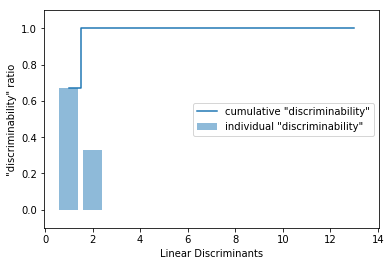

In [21]:
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14), discr, alpha=0.5, align='center', 
        label='individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid', 
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

As we can see in the resulting figure, the first two linear discriminants alone capture 100 percent of the useful information in the Wine training dataset. 

Let's now stack the two most discriminative eigenvector columns to create the transformation matrix $W$: 

In [22]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, 
               eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## Projecting samples onto the new feature space

Using the transformation matrix $W$ that we created in the previous subsection, we can now transform the training dataset by multiplying the matrices $X$ and $W$:

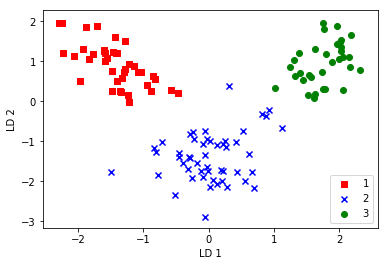

In [23]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], 
                X_train_lda[y_train==l, 1] * (-1), 
                c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

As we can see in the resulting pot, the three wine classes are now perfectly linearly separable in the new feature subspace. 

## LDA via scikit-learn

The step-by-step implementation was a good exercise to understand the inner workings of an LDA and understand the differentes between LDA and PCA. Now, let's look at the *LDA* class implemented in scikit-learn: 

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

Next, let's see how the logistic regressino handles the lower-dimensional training dataset after the LDA transformation:

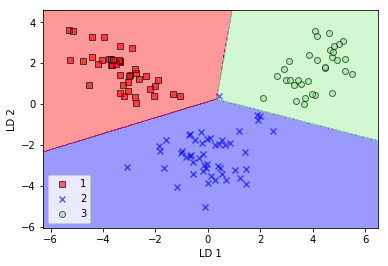

In [25]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

Looking at the resulting plot we see that the logistic regression model misclassifies one of the samples from class 2.

By lowering the regularization strength, we could probably shift the decision boundaries so that the logistic regression model classifies all samples in the training dataset correctly. However, and more importantly, let us take a look at the results on the test set:

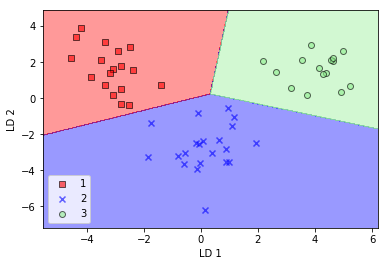

In [26]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

As we can see in the resulting plot, the logistic regression classifier is able to get a perfect accuracy score for classifying the samples in the test dataset by only using a two-dimensional feature subspace instead of the original 13 Wine features. 

## Using kernel principal component analysis for nonlinear mappings

Many machine learning algorithms make assumptions about the linear separability of the input data. You learned that the perceptron even requires perfectly linearly separable training data to converge. Other algorithms that we have covered so far assume that the lack of perfect linear separability is due to noise: Adaline, logistic regression, and the (standard) SVM just to name a few. 

However, if we are dealing with nonlinear problems, which we may encounter rather frequently in real-world applications, linear transformation techniques for dimensionality reduction, such as PCA and LDA, may not be the best choice. In this section, we will take a look at a kernelized version of PCA, or KPCA, which relates to the concepts of kernel SVM. Using kernel PCA, we will learn how to transform data that is not linearly separable onto a new, lower-dimensional subspace that is suitable for linear classifiers. 

<img src='images/05_11.png'>

## Kernel functions and the kernel trick

As we remember from our discussion about kernel SVMs, we can tackle nonlinear problems by projecting them onto a new feature space of higher dimensionality where the class become linearly separable. To transform the samples $x$ onto this higher *k*-dimensional subspace, we defined a nonlinear mapping function $\phi$: 

$$\phi : \mathbb{R}^d \rightarrow \mathbb{R}^k (k >> d)$$

We can think of $\phi$ as a function that creates nonlinear combinations of the original features to map the original $d$-dimensional dataset onto a larger, $k$-dimensional feature space. For example, if we had a feature vector $x \in \mathbb{R}^d$ ($x$ is a column vector consisting of $d$ features) with two dimensions ($d=2)$, a potential mapping onto a 3D-space could be: 

$$x = [x_1, x_2]^T$$

$$\downarrow \phi$$

$$z = [x_i^2, \sqrt{2x_1x_2}, x_2^2]^T$$

In other words, we perform a nonlinear mapping via kernel PCA that transforms the data onto a higher-dimensional space. When then we use stardard PCA in this higher-dimensional space to project the data back onto a lower-dimensional space where the samples can be separated by a linear classifier (under the condition that the samples can be separated by density in the input space). However, one downside of this approach is that it is computationally very expensive, and this is where we use the **kernel trick**. Using the kernel trick, we can compute the similarity between two high-dimension feature vectors in the original feature space. 

Before we proceed with more details about the kernel trick to tackle this computationally expensive problem, let us think back to the standard PCA approach that we implemented at the beginning of this chapter. We computed the covariance between two features $k$ and $j$ as follows: 

$$\sigma_{jk} = \frac{1}{n} \sum_{i=1}^n \left( x_j^{(i)} - \mu_j \right) \left( x_k^{(i)} - \mu_k \right)$$

Since the standardizing the features centers them at mean zero, for instance, $\mu_j = 0$ and $\mu_k = 0$, we can simplify this equation as follows: 

$$\sigma_{jk} = \frac{1}{n} \sum_{i=1}^n x_j^{(i)} x_k^{(i)}$$

Note that the preceding equation refers to the covariance between the two features, now, let us write the general equation to calculate the covariance matrix $\Sigma$:

$$\Sigma = \frac{1}{n} \sum_{i=1}^n x^{(i)} x^{(i)^T}$$

Bernhard Scholkopf generalized this approach so that we can replace the dot products between samples in the original feature space with the nonlinear feature combinations via $\phi$: 

$$\Sigma = \frac{1}{n} \sum_{i=1}^n \phi(x^{(i)}) \phi(x^{(i)})^T$$

To obtain the eigenvectors; the principal components, from this covariance matrix, we have to solve the following question: 

$$\Sigma v = \lambda v$$

$$ \Rightarrow \frac{1}{n} \sum_{i=1}^n \phi(x^{(i)}) \phi(x^{(i)})^T v = \lambda v$$

$$ \Rightarrow \frac{1}{n\lambda} \sum_{i=1}^n \phi(x^{(i)}) \phi(x^{(i)})^T v = \frac{1}{n} \sum_{i=1}^n a^{(i)} \phi(x^{(i)})$$

Here, $\lambda$ and $v$ are the eigenvalues and eigenvectors of the covariance matrix $\Sigma$, and $a$ can be obtained by extracting the eigenvectors of the kernel (similarity) matrix $K$, as we will see in the next paragraphs. 

As we recall from kernel SVM, we use the kernel trick to avoid calculating the pairwise dot products of the samples $x$ under $\phi$ explicitly by using a kernel function $\kappa$ so that we do not need to calculate the eigenvectors explicitly:

$$\kappa(x^{(i)}, x^{(j)}) = \phi(x^{(i)})^T \phi(x^{(j)})$$

In other words, what we obtain after kernel PCA are the samples already projected onto the respective components, rather than constructing a transformation matrix as in the standard PCA approach. Basically, the kernel function (or simply kernel) can be understood as a function that calculates a dot product between two vectors, a measure of similarity. 

The most commonly used kernels are as follows:
* The polynomial kernel: $\kappa(x^{(i)}, x^{(j)}) = (x^{(i)T} x^{(j)} + \theta)^\rho$. Here, $\theta$ is the threshold and $\rho$ is the power that has to be specified by the user. 
* The hyperbolic tangent (sigmoid) kernel: $\kappa(x^{(i)}, x^{(j)}) = \text{tanh}(\eta x^{(i)T} x^{(j)} + \theta)$. 
* The **Radial Basis Function (RBF)** or Gaussian kernel, which we will use in the following examples in the next subsection: $\kappa(x^{(i)}, x^{(j)}) = \exp \left( -\frac{||x^{(i)} - x^{(j)}||^2}{2\sigma^2} \right)$. It is often written in the following form, introducing the variable $\gamma = \frac{1}{2\sigma}$: $\kappa(x^{(i)}, x^{(j)}) = \exp \left( -\gamma ||x^{(i)} - x^{(j)}||^2 \right)$.

To summarize what he have learned so far, we can defined the following three steps to implement an RBF kernel PCA: 
1. We compute the kernel (similarity) matrix $K$.
2. We center the kernel matrix $K$ using the following equation: $K' = K - 1_nK - K1_n + 1_nK 1_n$. 
3. We collect the top $k$ eigenvectors of the centered kernel matrix based on their corresponding eigenvalues, which are ranked by decreasing magnitude. In contrast to standard PCA, the eigenvectors are not the principal component axes, but the samples already projected onto these axes. 

At this point, you may be wondering why we need to center the kernel matrix in the second step. We previously assumed that we are working with standardized data, where all features have mean zero when we formulated the covariance matrix and replaced the dot-products with the nonlinear feature combinations via $\phi$. Thus, the centering of the kernel matrix in the second step becomes necessary, since we do not compute the new feature space explicitly so that we cannot guarantee that the new feature space is also centered at zero. 

In the next section, we will put those three steps into action by implementing a kernel PCA in Python. 

## Implementing a kernel principal component analysis in Python

In the previous subsection, we discussed the core concepts behind kernel PCA. Now, we are going to implement an RBF kernel PCA in Python following the three steps that summarized the kernel PCA approach. Using some SciPy and NumPy helper functions, we will see that implementing a kernel PCA is actually really simple: 

In [31]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation. 
    
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
    
    gamma: float
        Tuning parameter of the RBF kernel
    
    n_components: int
        Number of principal components to return
        
    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
        Projected dataset
    """
    
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimesional dataset. 
    sq_dists = pdist(X, 'sqeuclidean')
    
    # Convert pairwise distances into a square matrix. 
    mat_sq_dists = squareform(sq_dists)
    
    # Compute the symmetric kernel matrix. 
    K = exp(-gamma * mat_sq_dists)
    
    # Center the kernel matrix. 
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, i] for i in range(n_components)))
    
    return X_pc

One downside of using an RBF kernel PCA for dimensionality reduction is that we have to specify the $\gamma$ parameter a priori. Finding an appropriate value for $\gamma$ requires experimentation and is best done using algorithms for parameter tuning, for example, performing a grid search, which we will discuss in more detail later. 

## Example 1 - separating half-moon shapes

Now, let us apply our *rbf_kernel_pca* on some nonlinear example datasets. We will start by creating a two-dimensional dataset of 100 sample points representing two half-moons shapes: 

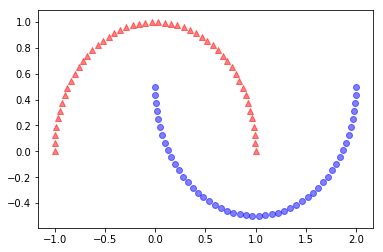

In [28]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', 
            marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', 
            marker='o', alpha=0.5)
plt.show()

For the purpose of illustration, the half-moon of triangle symbols shall represent one class, and the half-moon depicted by the circle symbols represent the samples from another class. 

Clearly, these two half-moon shapes are not linearly separable, and our goal is to *unfold* the half-moons via kernel PCA so that the dataset can serve as a suitable input for a linear classifier. But first, let's see how the dataset looks if we project it onto the principal components via standard PCA: 

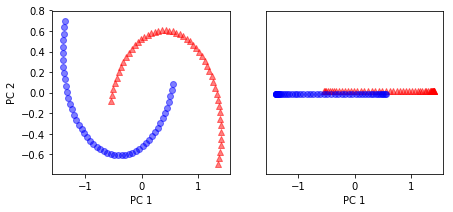

In [29]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], 
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], 
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50,1))+0.02, 
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1))-0.02, 
              color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')
plt.show()

Note that when we plotted the first principal component only (right subplot), we shifted the triangular samples slightly upwards and the circular samples slightly downwards to better visualize the class overlap. As the left subplot shows, the original half-moon shapes are only slightly sheared and flipped across the vertical center, this transformation would not help a linear classifier in discriminating between circles and triangles. Similarly, the circles and triangles corresponding to the two half-moon shapes are not linearly separable if we project the dataset onto a one-dimensional feature axis, as shown in the right subplot. 

Please remember that PCA is an unsupervised method and does not use class label information in order to maximize the variance contrast to LDA. Here, the triangle and circle symbols were just added for visualization purposes to indicate the degree of separation. 

Now, let us try out our kernel PCA function *kbf_kernel_pca*, which we implemented in the previous subsection:

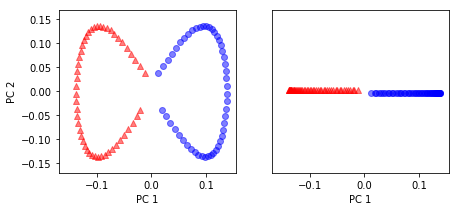

In [32]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], 
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02, 
              color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')
plt.show()

We can now see that the two classes (*circles* and *triangles*) are linearly well separated so that it becomes a suitable training dataset for linear classifiers. 

Unfortunately, there is no universal value for the tuning parameter $\gamma$ that works well for different datasets. Finding a $\gamma$ value that is appropriate for a given problem requires experimentation. In next chapter, we will discuss techniques that can help us to automate the task of optimizing such tuning parameters. Here, I will use values for $\gamma$ that I found produce good results. 

## Example 2 - separating concentric circles

In the previous subsection, we showed how to separate half-moon shapes via kernel PCA. Since we put so much effort into understanding the concepts of kernel PCA, let us take a look at another interesting example of a nonlinear problem, concentric circles: 

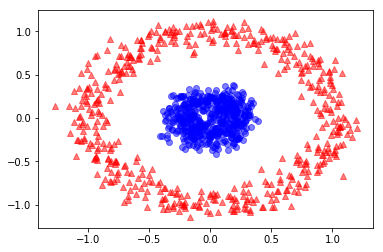

In [33]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, 
                    noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', 
            marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', 
            marker='o', alpha=0.5)
plt.show()

Again, we assume a two-class problem where the triangle shapes represent one class, and the circle shapes represent another class. 

Let's start with the standard PCA approach to compare it to the results of the RBF kernel PCA: 

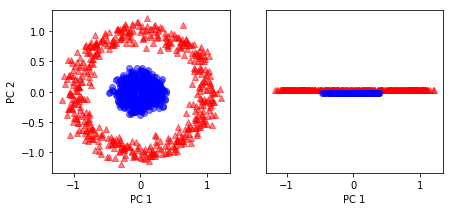

In [36]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], 
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], 
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500,1))+0.02, 
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500,1))-0.02, 
              color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')
plt.show()

Again, we can see that standard PCA is not able to produce results suitable for training a linear classifier. 

Given an appropriate value for $\gamma$, let us see if we are luckier using the RBF kernel PCA implementation: 

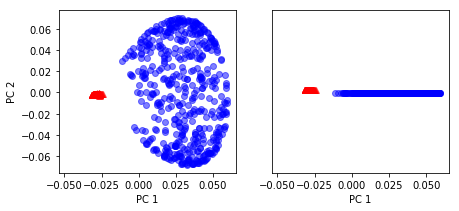

In [37]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], 
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1))+0.02, 
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1))-0.02, 
              color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')
plt.show()

Again, the RBF kernel PCA projected the data onto a new subspace where the two classes become linearly separable. 

## Projecting new data points

In the previous example applications of kernel PCA, the half-moon shapes and the concentric circles, we projected a single dataset onto a new feature. In real applications, however, we may have more than one dataset that we want to transform, for example, training and test data, and typically also new samples we will collect after the model building and evaluation. In this section, you will learn how to project data points that were not part of the training dataset. 

As we remember from the standard PCA approach at the beginning of this chapter, we project data by calculating the dot product between a transformation matrix and the input samples; the columns of the projection matrix are the top $k$ eigenvectors ($v$) that we obtained from the covariance matrix. 

Now, the question is how we can transfer this concept to kernel PCA. If we think back to the idea behind kernel PCA, we remember that we obtained en eigenvector ($a$) of the centered kernel matrix (not the covariance matrix), which means that those are the samples that are already projected onto the principal component axis $v$. Thus, if we want to project a new sample $x'$ onto this principal component axis, we would need to compute the following: 

$$\phi(x')^T v$$

Fortunately, we can use the kernel trick so that we do not have to calculate the projection explicitly. However, it is worth nothing that kernel PCA, in contrast to standard PCA, is a memory-based method, which means that we have to re-use the original training set each time to project new samples. We have to calculate the pairwise RBF kernel (similarity) between each $i$th sample in the training dataset and the new sample $x'$: 

$$\phi(x')^T v = \sum_{i} a^{(i)} \phi(x')^T \phi(x^{(i)}) = \sum_{i} a^{(i)} \kappa(x', x^{(i)})$$

Here, the eigenvectors $a$ and eigenvalues $\lambda$ of the kernel matrix $K$ satisfy the following condition in the equation: 

$$Ka = \lambda a$$

After calculating the similarity between the new samples and the samples in the training set, we have to normalize the eigenvector $a$ by its eigenvalue. Thus, let us modify our *rbf_kernel_pca* function that we implemented earlier so that it also returns the eigenvalues from the kernel matrix:

In [38]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation. 
    
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
    
    gamma: float
        Tuning parameter of the RBF kernel
    
    n_components: int
        Number of principal components to return
        
    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
        Projected dataset
        
    lambdas: list
        Eigenvalues
    """
    
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimesional dataset. 
    sq_dists = pdist(X, 'sqeuclidean')
    
    # Convert pairwise distances into a square matrix. 
    mat_sq_dists = squareform(sq_dists)
    
    # Compute the symmetric kernel matrix. 
    K = exp(-gamma * mat_sq_dists)
    
    # Center the kernel matrix. 
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, i] for i in range(n_components)))
    
    # Colect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas

Now, let's create a new half-moon dataset and project it onto a one-dimensional subspace using the updated RBF kernel PCA implementation: 

In [39]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

To make sure that we implemented the code for projecting new samples, let us assume that the 26th point from the half-moon dataset is a new data point $x'$, and our task is to project it onto this new subspace: 

In [40]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [41]:
x_proj = alphas[25] # original projection
x_proj

array([0.0788])

In [42]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

By using the following code, we are able to reproduce the original projection. Using the *project_x* function, we will be able to project any new data sample as well. The code is as follows: 

In [43]:
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([0.0788])

Lastly, let's visualize the projection on the first principal component: 

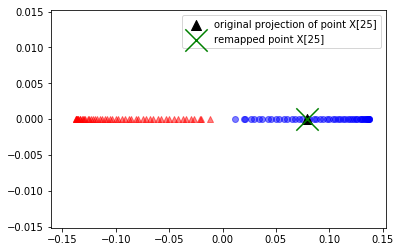

In [45]:
plt.scatter(alphas[y==0, 0], np.zeros((50)), 
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), 
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, 
            color='black', 
            label='original projection of point X[25]', 
            marker='^', s=100)
plt.scatter(x_reproj, 0, 
            color='green', 
            label='remapped point X[25]', 
            marker='x', s=500)
plt.legend(scatterpoints=1)
plt.show()

As we can now also see in the resulting scatterplot, we mapped the sample $x'$ onto the first principal component correctly. 

## Kernel principal component analysis in scikit-learn

For our convenience, scikit-learn implements a kernel PCA class in *sklearn.decomposition* submodule. The usage is similar to the standard PCA class, and we can specify the kernel via the *kernel* parameter: 

In [46]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', 
                        gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

To check that we get results that are consistent with our own kernel PCA implementation, let's plot the transformed half-moon shape data onto the first two principal components: 

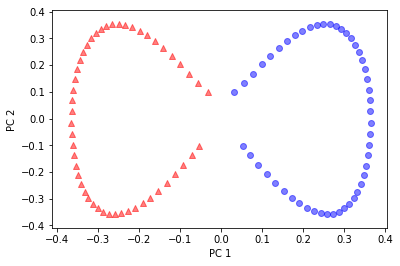

In [47]:
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], 
            color='blue', marker='o', alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

As we can see, the results of scikit-learn's *KernelPCA* are consistent with our own implementation. 

# Summary

In this chapter, you learned about three different, fundamental dimensionality reduction techniques for feature extraction: standard PCA, LDA, and kernel PCA. Using PCA, we projected data onto a lower-dimensional subspace to maximize the variance along the orthogonal feature axes, while ignoring the class labels. LDA, in contrast to PCA, is a technique for supervised dimensionality reduction, which means that it considers class information in the training dataset to attempt to maximize the class-separability in a linear feature space. 

Lastly, you learned about a nonlinear feature extractor, kernel PCA. Using the kernel trick and a temporary projection into a higher-dimensional feature space, you were ultimately able to compress datasets consisting of nonlinear features onto a lower-dimensional subspace where the classes became linearly separable. 

Equipped with these essential preprocessing techniques, you are now well prepared to learn about the best practices for efficiently incorporating different preprocessing techniques and evaluating the performance of different models in the next chapter. 